<a href="https://colab.research.google.com/github/cunhamaicon/mias/blob/master/mias_project_preproc1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Banco de dados: MIAS

**Pré - processamento das imagens do MIAS**


** Autor: Maicon Henrique Cunha**

Github: [https://github.com/cunhamaicon](https://)

## Informações:

Originalmente encontrado em [www.mammoimage.org/databases/](http://www.mammoimage.org/databases/) é um banco público de imagens de mamografias juntamente com as anotações de especialistas. Entre as anotações se encontram: característica, anormalidade, severidade, coordenadas x e y do centro da anormalidade e raio aproximado da anormalidade. Informações detalhadas podem ser encontradas em [info.txt](https://github.com/cunhamaicon/mias/blob/master/Info.txt). Nesse tratamento será considerado apenas a variável severidade, o objetivo será fazer um tratamento das imagens para identificar aquelas cujo diagnóstico seja descrito como maligno em futura implementação com redes neurais convolucionais. O banco de dados, assim como as anotações estão  [aqui](https://github.com/cunhamaicon/mias) e todo o código pode ser executado on line pelo [colab](https://colab.research.google.com).

## Arquivos:


1.   info_images.csv - contém anotações das imagens retiradas de Info.txt
2.   Info.txt - informações gerais
3.   Licence.txt - informações sobre a utilização das imagens
4.   Pasta img com 322 imagens no formato pgm

##Objetivos:



1.   Remover registros duplicados de info_images.csv
2.   Remover registros com erros de info_images.csv
3.   Fazer um pré tratamento das imagens obtendo apenas a mama
4. Explorar técnicas de tratamento de imagem para ultrassonagrafia
5.   Mostrar as etapas do processamento de imagem
6. Relizar testes para obter a melhor forma de processar a imagem para futura implementação em redes convolucionais
---



## Procedimentos iniciais

###Download

Fazendo o download do banco de dados que previamente foi transferido para uma pasta no meu github:

In [0]:
!git clone https://github.com/cunhamaicon/mias

Cloning into 'mias'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (328/328), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 328 (delta 136), reused 328 (delta 136), pack-reused 0
Receiving objects: 100% (328/328), 103.67 MiB | 23.00 MiB/s, done.
Resolving deltas: 100% (136/136), done.
Checking out files: 100% (325/325), done.


Mostrando os arquivos da pasta:

In [0]:
ls mias

img/  info_images.csv  Info.txt  Licence.txt


### importação de pacotes

Importação dos pacotes utilizados:

In [0]:
import pandas as pd
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

### Dataframe

Criando o dataframe **data** no pandas a partir do arquivo info_images.csv:

In [0]:
datadir='mias'
data = pd.read_csv(os.path.join(datadir, "info_images.csv"))
data['Image'] = data['Image']+'.pgm'
pd.set_option('display.max_colwidth',-1)

Mostrando o cabeçalho de **data**:

In [0]:
data.head()

,Image,Character,Abnormality,Severity,x_coordinate,y_coordinate,radius
0,mdb001.pgm,G,CIRC,B,535,425,197.0
1,mdb002.pgm,G,CIRC,B,522,280,69.0
2,mdb003.pgm,D,NORM,NaN,NaN,NaN,NaN
3,mdb004.pgm,D,NORM,NaN,NaN,NaN,NaN
4,mdb005.pgm,F,CIRC,B,477,133,30.0


Verificação do tamanho de data:

In [0]:
print(len(data))

330


O tamanho de data é 330 mas existem apenas 322 imagens, o que não era esperado. Vamor verificar se existem arquivos repetidos, isso é, se existe mais de uma referência para uma mesma imagem.

### Registros duplicados

Defininindo uma função que busca por registros repetidos em um dataframe por coluna:

In [0]:
def duplicates_df_column(df,column):
  
  """Daddo um dataframe(df) e uma coluna(column), retorna
  os índices onde houve duplicação de respostas pela coluna analisada"""
  
  duplicates=[]

  for i in range(len(data)-1):
    for j in range(i+1,len(data)):
      if data['Image'][i]==data['Image'][j]:
        duplicates.append(i)
        duplicates.append(j)

  duplicates = list( dict.fromkeys(duplicates) )
  
  return duplicates

Aplicando a função "duplicates_df_column" no caso de estudo:

In [0]:
duplicates = duplicates_df_column(data,'Image')

Exibindo os registros de data que estão duplicados:

In [0]:
data.loc[duplicates]

,Image,Character,Abnormality,Severity,x_coordinate,y_coordinate,radius
4,mdb005.pgm,F,CIRC,B,477,133,30.0
5,mdb005.pgm,F,CIRC,B,500,168,26.0
132,mdb132.pgm,F,CIRC,B,252,788,52.0
133,mdb132.pgm,F,CIRC,B,335,766,18.0
145,mdb144.pgm,F,MISC,B,233,994,29.0
146,mdb144.pgm,F,MISC,M,313,540,27.0
225,mdb223.pgm,D,CALC,B,523,482,29.0
226,mdb223.pgm,D,CALC,B,591,529,6.0
229,mdb226.pgm,D,CALC,B,287,610,7.0
230,mdb226.pgm,D,CALC,B,329,550,25.0


Observações:



1.   A imagem mdb144.pgm é inconsistente pois seus dois registro possuem atributo "Severity" diferentes e deve ser excluída de qualquer análise
2.   Se o objetivo do estudo for apenas detectar maligno, benigno sem a utilização das variáveis "x_coordinate",	"y_coordinate"	e "radius" qualquer um dos registros duplicados pode ser removido, pois "Character" ,	"Abnormality"e	"Severity" não mudam nas duplicações. Como o banco de imagens é pequeno, toda imagem é importante e se possível deve ser mantida
3. Vou considerar que as variáveis "x_coordinate",	"y_coordinate"	e "radius" não serão utilizadas para excluir os registros duplicados nesse procedimento




Escolhendo os registro a serem excluídos com base nas observações anteriores e fazendo a remoção em data:

In [0]:
duplicates = [4, 132, 145,146, 225, 229,230, 244, 255]
data = data.drop(duplicates)

Verificação do tamanho de data:

In [0]:
print(len(data))

321


### Lista Imagens

Criando um array com o endereço das imagens:

In [0]:
image_path =[]
datadir2 = 'mias/img'

for img in data['Image'][:]:
  image_path.append( os.path.join(datadir2, img))
  
image_paths=np.asarray(image_path)



---
## **Processamento das imagens**


---




### Mostrando uma imagem aleatória:

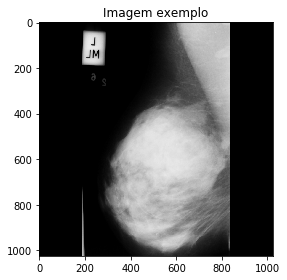

In [0]:
image = image_path[random.randint(0, len(image_path))]
plt.imshow(cv2.imread(image), cmap = "gray")
plt.title("Imagem exemplo")
plt.tight_layout()

Observações:


1.   Em alguns casos o registro da mama esquerda ou direita aparece na imagem, o que é indesejado e será tratado no pré-processamento da imagem
2.   As bordas podem ser excluídas da imagem
3. Demais procedimentos técnicos devem ser analisados



---





### Normalização

In [0]:
def normalize(img):
  
  """Retorna a imagem normalizada. Com valores entre 0 e 1"""
  
  return img/255

### Verificação da dimensão da imagem:

In [0]:
print(cv2.imread(image).shape)

(1024, 1024, 3)


Observaçoes:

1.   Tamanho da imagem checado 1024x1024
2.   A imagem está em rgb, apesar de não parecer e deve ser alterada para escala de cinza
3. Como a mudança para escala de cinza é de caráter técnico não será feita nova visualização da imagem em escala de cinza


### Escala de cinza

In [0]:
def grayscale(img):
  
  """Dada uma imagem de entrada(img) retorna a mesma imagem em escala de cinza"""
  
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### Normalização Global 

Procedimento padrão em se tratando de imagens de ultrassom é normalização global, definido a seguir. Como a normalização não altera a visualização da imagem sendo de caráter técnico não será exibida uma nova imagem.

In [0]:
def gcn(img):
  
  """Dada uma imagem retorna a mesma normalizada globalmente. Essa função só 
  pode ser utilizada em imagens em escala de cinza"""
  
  h,w=img.shape
  img=img - sum(img)/(h*w)
  return img

### Recorte das bordas

Definindo a função que recorta as bordas de uma imagem em escala de cinza:

In [0]:
def cropped_image(img, width_cut, height_cut):
  
  """Dada uma imagem  de entrada(img), o tamanho do corte nas bordas com relação
  a altura ( height_cut) e o tamanho do corte nas bordas com relação ao
  comprimento(width_cut), retorna a imagem cortada. Uma verificação é feita no
  tamanho do corte que não pode exceder o tamanho da imagem para evitar inconsistências."""
  
  height_img, width_img = img.shape  
  
  if width_cut*2 < width_img and height_cut*2 < height_img:  
    
    cropped_img=img[height_cut:height_img-height_cut,width_cut:width_img-width_cut]

  return cropped_img

Visualização de uma imagem cortada em 32 pixels na altura e no comprimento:

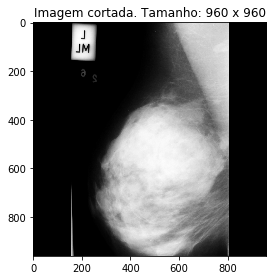

In [0]:
image2= cv2.imread(image)
image2 = grayscale(image2)
image2=cropped_image(image2,32,32)


title_size = "Imagem cortada. Tamanho: {} x {}".format(str(image2.shape[1]),str(image2.shape[0]))
plt.title( title_size)

plt.imshow(image2, cmap = "gray")
plt.tight_layout()

### Equalização da imagem

Definindo a função que faz a equalização da imagem:

In [0]:
def equalize(img):
  return cv2.equalizeHist(img)

Visualizando uma imagem equalizada:

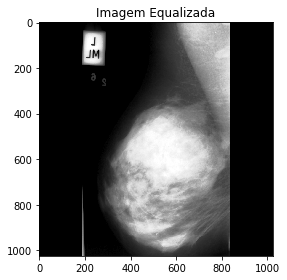

In [0]:
image2 = image
image2=cv2.imread(image2)
image2 = grayscale(image2)
image2 = equalize(image2)

plt.title('Imagem Equalizada')
plt.imshow(image2, cmap = "gray")
plt.tight_layout()
  

### Intensidade da imagem

Definindo a função que procura pontos de intensidade definidos em um intervalo de 0 a 1, onde 0 é preto e 1 é branco:

In [0]:
def intensity_points(img,n_min,n_max):
  
  """Entradas img: nome da imagem
     nmin: intensidade mínima desejada
     n_max: intensidade máxima desejada
     Retorna uma imagem com gradação entre o mínimo e o máximo
     Obs:
     1.A imgem não pode estar normalizada ou a função deve ser ajustada.
     2. A imagem deve estar em escala de cinza.
     
  """
  
  img_intensity=[]
  
  height,width = img.shape
  total = height*width
  img=img.reshape(total)
  
  for i in range(total):
    if img[i]>255*n_min and img[i]<255*n_max :
      img_intensity.append(img[i])
    else:
      img_intensity.append(0)
  
  return np.asarray(img_intensity).reshape(height,width)

Visualizando uma imagem selecionando a intensidade entre 0.3 e 1

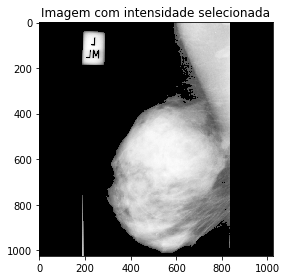

In [0]:
image2 = image
image2 = cv2.imread(image2)
image2 = grayscale(image2)
image2 = intensity_points(image2,0.3,1)

plt.title('Imagem com intensidade selecionada')
plt.imshow(image2, cmap = "gray")
plt.tight_layout()

### Maior objeto

Definindo a função que pega o maior objeto da imagem para eliminar as anotações de esquerda e direita(por exemplo):

In [0]:
def get_great(img):
  
  """Função que seleciona o maior objeto da imagem"""
    
  threshold = 0.25

# transformar imagem em binary com o threshol
  ret,thresh1 = cv2.threshold(img, threshold*255,255,cv2.THRESH_BINARY)

# funcao que pega maior objeto da imagem
  def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 1
    img2 = np.int8(img2)
    return(img2)


  imagem_corrigida = undesired_objects(thresh1)

  merged = cv2.bitwise_and(img, img , mask=imagem_corrigida)

  return merged

Visualizando uma imagem depois de aplicar o procedimento de pegar o maior objeto(mama)

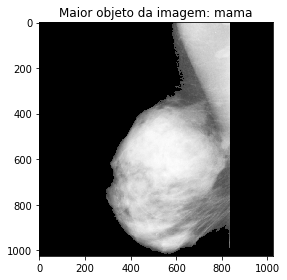

In [0]:
image2 = image
image2 = cv2.imread(image2)
image2=grayscale(image2)
image2 = get_great(image2)

plt.title('Maior objeto da imagem: mama')
plt.imshow(image2, cmap = "gray")
plt.tight_layout()


Definindo uma função que retorna o centro do maior objeto da imagem:

In [0]:
def get_great_center(img):
  
  height_img, width_img = img.shape
  
  """Função que dada uma imagem seleciona o maior objeto e retorna
  o centro desse objeto"""
    
  threshold = 0.25

# transformar imagem em binary com o threshol
  ret,thresh1 = cv2.threshold(img, threshold*255,255,cv2.THRESH_BINARY)

# funcao que pega maior objeto da imagem
  def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    
    
    ch,cw =centroids[0]    
    
    ch = int(ch)
    cw=int(cw)    

    return ch,cw


  ch,cw = undesired_objects(thresh1)

  return ch,cw

Testando a função:

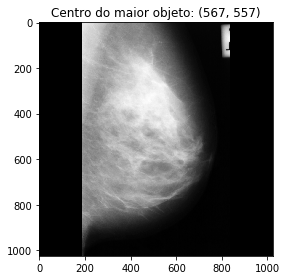

In [0]:
image = image_path[random.randint(0, len(image_path))]
image2 = image
image2 = cv2.imread(image2)
image2=grayscale(image2)

center = str(get_great_center(image2))

plt.imshow(image2, cmap = "gray")
plt.title("Centro do maior objeto: " + center)
plt.tight_layout()


### Quadrados inscritos: possibilidade ; seleção ; recorte

Definindo uma função que verifica se em uma imagem com um determinado centro é possível inscrever um quadrado de um tamanho específico.

In [0]:
def square_possible(img, center_h, center_w, size):
  
  """Dada uma imagem (img) e as coordenadas de um ponto(center_h, center_w).
  A função retorna True se for possível inscrever um quadrado de tamanho(size)
  na imagem a partir desse ponto ou False, caso contrário."""
  
  height_img, width_img = img.shape 
  
  dist_centerh_bord = min(center_h, height_img-center_h)
  dist_centerw_bord = min(center_w, width_img-center_w)
  
  if dist_centerh_bord>=size/2 and dist_centerw_bord>=size/2:
    possible=True
  else:
    possible = False
  
  return possible

Verificando o funcionamento da função:

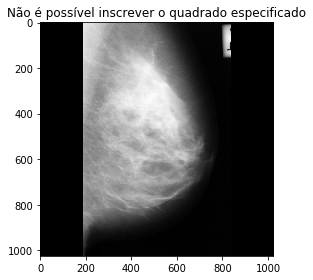

In [0]:
image2 = image
image2 = cv2.imread(image2)
image2=grayscale(image2)

quadrado = square_possible(image2,200,200,401)

if quadrado:
  title_square='É possível inscrever o quadrado especificado'
else:
  title_square='Não é possível inscrever o quadrado especificado'

plt.title(title_square)
plt.imshow(image2, cmap = "gray")
plt.tight_layout()

Definindo uma função que seleciona um quadrado em uma imagem de um tamanho específico a partir do centro quando for possível. Se não for possível retorna o maior quadrado possível a partir desse centro.

In [0]:
def select_square(img, center_h,center_w,size):
  
  """Dada uma imagem(img) as coordenadas do centro (center_h,center_w),
  e o tamanho do quadrado(size). A função retorna a imagem apenas com a seleção
  do quadrado. Se não for possível encontrar um quadrado de tamanho size, a função
  retorna o maioor quadrado possível"""
   
  while not square_possible(img,center_h,center_w,size):
    size-=1
    
  size=int(size)
    
  if size%2!=0:
    size-=1
  
  img2=img.copy()
  
  halfsize=size/2
  
  height_img, width_img = img.shape
  
  h_min,  h_max=  center_h - halfsize,center_h + halfsize
  w_min,  w_max=  center_w - halfsize,center_w + halfsize
 
  for i in range(height_img):
    for j in range(width_img):
      if i < h_min or i > h_max or j<w_min or j>w_max:
        img2[i,j]=0
  
  return img2

Verificando o funcionamento da função:

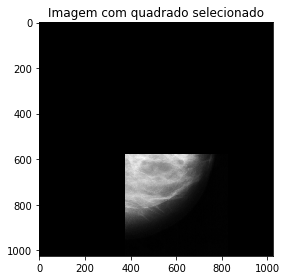

In [0]:
image2 = image
image2 = cv2.imread(image2)
image2=grayscale(image2)

image2 = select_square(image2,800,600,800)

plt.title('Imagem com quadrado selecionado')
plt.imshow(image2, cmap = "gray")
plt.tight_layout()

Definindo uma função que recorta um quadrado em uma imagem de um tamanho específico a partir do centro quando for possível. Se não for possível retorna o maior quadrado possível a partir desse centro.

In [0]:
def select_square_crop(img, center_h,center_w,size):
  
  """Dada uma imagem(img) as coordenadas do centro (center_h,center_w),
  e o tamanho do quadrado(size). A função retorna a imagem apenas com o recorte
  do quadrado. Se não for possível encontrar um quadrado de tamanho size, a função
  retorna o maior quadrado possível"""
  
   
  while not square_possible(img,center_h,center_w,size):
    size-=1
    
  if size%2!=0:
    size-=1
  
    
  halfsize=size/2
  
  height_img, width_img = img.shape
  
  h_min,  h_max=  int(center_h - halfsize),int(center_h + halfsize)
  w_min,  w_max=  int(center_w - halfsize),int(center_w + halfsize)
 
  img2=np.zeros((size,size))
  
  img2[:,:]=img[h_min:h_max,w_min:w_max]
  

  return img2

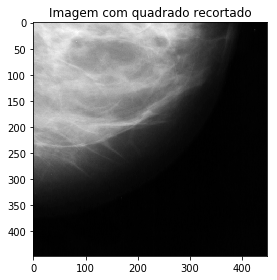

In [0]:
image2 = image
image2 = cv2.imread(image2)
image2=grayscale(image2)

image2 = select_square_crop(image2,800,600,800)

plt.title('Imagem com quadrado recortado')
plt.imshow(image2, cmap = "gray")
plt.tight_layout()

### Todo o processamento

Definindo uma função que faz os processamentos na ordem desejada:

In [0]:
def preprocess(img):
  
  """Dada uma imagem retorna a imagem pré-processada"""
  
  img = cv2.imread(img)
  img = grayscale(img)
  img = cropped_image(img,32,32)    
  img = cv2.resize(img,(256,256))  
  img = equalize(img) 
  ch,cw = get_great_center(img)    
  img = get_great(img)  
  img = select_square_crop(img,ch,cw,167)    
  img = intensity_points(img,0.3,1)
  img = cv2.resize(img,(256,256))
  img=normalize(img)  
 
  
  return img

Visualizando uma imagem pré processada

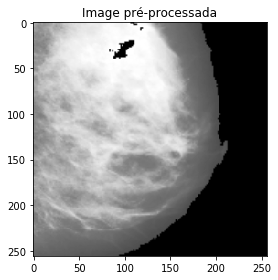

In [0]:
image2 = preprocess(image)

plt.title('Image pré-processada')
plt.imshow(image2, cmap = "gray")
plt.tight_layout()





---


## Testes


---



Fim do pré-processamento. Realização de teste testes para verificar as imagens antes e depois da etapa de processamento.

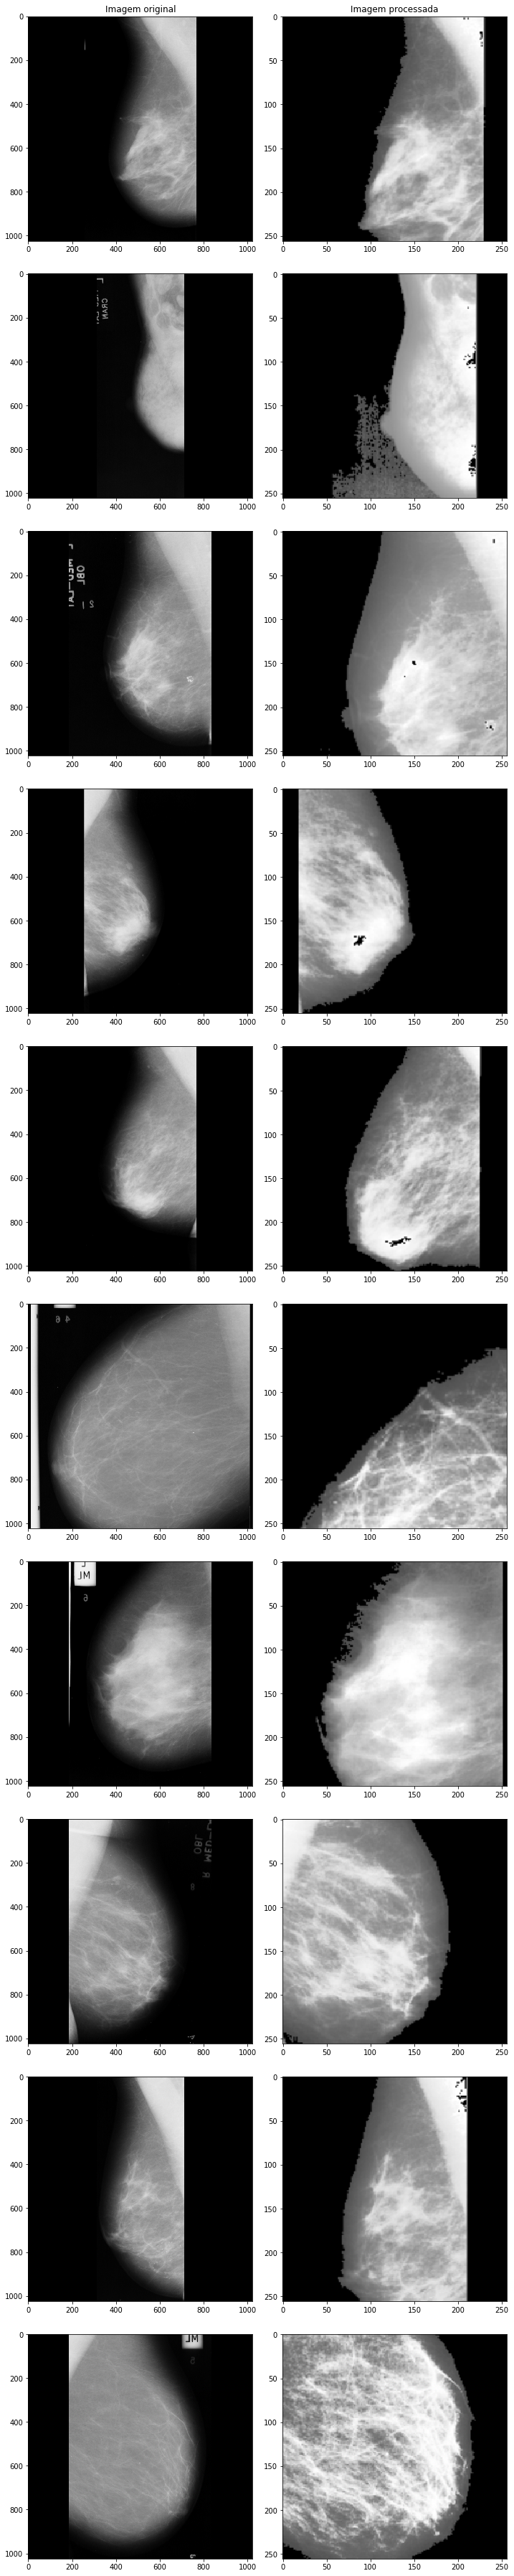

In [0]:
ncol = 2
nrow = 10


fig, axs = plt.subplots(nrow,ncol, figsize=(10,50))
fig.tight_layout()

for i in range(nrow):
  image = image_path[random.randint(0, len(image_path))]
  
  image_original = cv2.imread(image)
  
  image_process= preprocess(image)
  
  for j in range(ncol):
    axs[i][0].imshow(image_original,cmap='gray')
    axs[i][1].imshow(image_process,cmap='gray')
    
    if i==0:
      axs[i][0].set_title('Imagem original')
      axs[i][1].set_title('Imagem processada')
      
    